In [1]:
import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium.wrappers import ResizeObservation
import imageio

import torch
import torch.nn as nn
from torchvision import transforms
from resnet.models import ResNet

import ray
from ray.rllib.models import ModelCatalog
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env

In [4]:
ENV = 'MsPacman-v4'
NUM_WORKERS = 2
OBS_SIZE = 112
CHECKPOINT = '/home/ben/ray_results/PPO_MsPacman-v4_2023-09-12_11-16-09dsh0e7ad/checkpoint_000010/'

In [5]:
env = gym.make(ENV)
# env = gym.make("CartPole-v1")
print(env.observation_space.shape)
env = ResizeObservation(env, 112)
print(env.observation_space.shape)
env.close()

(210, 160, 3)
(112, 112, 3)


In [6]:
env = gym.make(ENV, render_mode='human')
env = ResizeObservation(env, 112)

observation, info = env.reset()


for _ in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

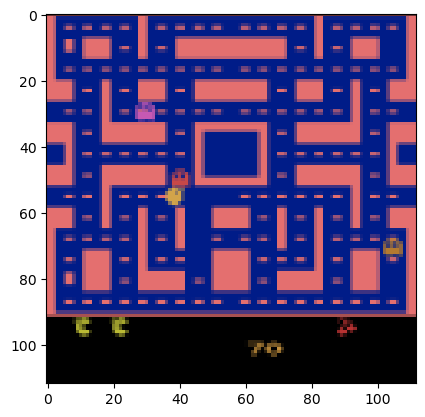

In [7]:
plt.imshow(observation)

In [6]:
def env_creator(env_config):

    # wrapper = gym.wrappers.AtariPreprocessing
    env = gym.make(ENV)
    # wrapped = wrapper(
    #     env, 
    #     frame_skip=1,
    #     screen_size=224,
    #     scale_obs=False, 
    #     grayscale_obs=False
    #     )
    
    render_mode = env_config['render_mode']
    env = gym.make(ENV, render_mode=render_mode)

    return env

In [7]:
class ResNetDQN(nn.Module):
    def __init__(self, in_channels, num_blocks, n_actions) -> None:
        super(ResNetDQN, self).__init__()
        self.encoder = ResNet(in_channels, num_blocks)
        self.linear = nn.Linear(256, n_actions)

    def forward(self, x) -> torch.Tensor:
        x = self.encoder(x)
        x = self.linear(x)
        return x

In [8]:
test_model = ResNetDQN(in_channels=3, num_blocks=3, n_actions=5)
x = torch.rand(size=(1,3,112,112))

with torch.no_grad():
    y = test_model(x)
print(y)

tensor([[ 0.0374,  0.4387, -0.4588,  0.5947, -0.3035]])


In [9]:
ray.shutdown()
ray.init(ignore_reinit_error=True, include_dashboard=True)

2023-09-26 08:49:56,040	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.5.0


In [35]:
register_env('pac-man', env_creator)

In [10]:
class CustomTorchModel(TorchModelV2, nn.Module):
    
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        self.encoder = ResNet(in_channels=3, num_blocks=3)
        self.policy_fc = nn.Linear(in_features=256, out_features=action_space.n)
        self.value_fc = nn.Linear(in_features=256, out_features=1)
    
    def forward(self, input_dict, state, seq_lens):
        is_training = input_dict.is_training
        observation = input_dict['obs']
        
        tensor = torch.moveaxis(observation, -1, 1)
        encoded_obs = self.encoder(tensor)
        logits = self.policy_fc(encoded_obs)
        self.state_value = self.value_fc(encoded_obs)

        return logits, []
    
    def value_function(self):
        return self.state_value.squeeze(-1)

ModelCatalog.register_custom_model("my_torch_model", CustomTorchModel)

In [14]:
model_config = {
    'custom_model': 'my_torch_model',
    'custom_model_config': {},
    'dim': OBS_SIZE
}

config = PPOConfig()

# config = ppo.PPO(env='pac-man', config=algo_config)
config.env_config.update({'render_mode': None})

# Define the environment
config = config.environment(ENV)

# Give or do not give access to the gpu
config = config.resources(num_gpus=0)

# Set the number of training roll out workers
config = config.rollouts(num_rollout_workers=NUM_WORKERS)

config.model.update(model_config)

# Set the max number of episode steps
# config.horizon = 30

# Set the number of evaluation workers
# config = config.evaluation(evaluation_num_workers=1)

# Set framework to pytorch
config = config.framework('torch')

# These lines are needed to avoid using the RL Module API currently in Alpha
# config = config.rl_module( _enable_rl_module_api=False)
# config = config.training(_enable_learner_api=False)


In [15]:
print(config.exploration_config)
print(config.env_config)
print(config.model)

{'type': 'StochasticSampling'}
{'render_mode': None}
{'_disable_preprocessor_api': False, '_disable_action_flattening': False, 'fcnet_hiddens': [256, 256], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'post_fcnet_hiddens': [], 'post_fcnet_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': False, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'use_attention': False, 'attention_num_transformer_units': 1, 'attention_dim': 64, 'attention_num_heads': 1, 'attention_head_dim': 32, 'attention_memory_inference': 50, 'attention_memory_training': 50, 'attention_position_wise_mlp_dim': 32, 'attention_init_gru_gate_bias': 2.0, 'attention_use_n_prev_actions': 0, 'attention_use_n_prev_rewards': 0, 'framestack': True, 'dim': 112, 'grayscale': False, 'zero_mean': True, 'custom_model': 'my_torch_model', 'custom_model_config': {}, 'custom_

In [16]:
if Path(CHECKPOINT).exists():
    print('Loading model from {}'.format(CHECKPOINT))
    algo = Algorithm.from_checkpoint(CHECKPOINT)
else:
    print('Training a new model...')
    algo = config.build()

Training a new model...


(RolloutWorker pid=9796) A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RolloutWorker pid=9796) [Powered by Stella] [repeated 2x across cluster]
2023-09-26 09:26:02,764	WARNING util.py:68 -- Install gputil for GPU system monitoring.


In [17]:
TRAINING_ITERATIONS = 10
EVAL_INTERVAL = 1
CHECKPOINT_INTERVAL = 5
checkpoint_paths = []


for i in tqdm.tqdm(range(TRAINING_ITERATIONS), 'Training Progress'):
    
    algo.train()

    if (i+1) % CHECKPOINT_INTERVAL == 0:
        checkpoint_paths.append(algo.save())
        # metrics = algo.evaluate()['evaluation']
        # rewards.append(metrics['episode_reward_mean'])
        # lengths.append(metrics['episode_len_mean'])
        # plot_metrics(rewards, lengths)

print(checkpoint_paths[-1])

Training Progress: 100%|██████████| 10/10 [1:29:45<00:00, 538.57s/it]

/home/ben/ray_results/PPO_MsPacman-v4_2023-09-26_09-25-57s2i6x535/checkpoint_000010


It appears that the newer version of ray automatically attempts to transform the observation based model configurations. In older versions if you had to perform the transformation step yourself. Thus, the cell block below is no longer necessary and will give an error if you attempt to transform the observation before it is passed to the ray algorithm.

In [19]:
env = gym.make(ENV)
# env = ResizeObservation(env, 112)
observation, info = env.reset()
print(observation.shape)
action = algo.compute_single_action(observation)
print(action)
env.close()
# transformer = transforms.ToTensor()
# tensor = transformer(observation).unsqueeze(0)
# print(tensor.shape)

(210, 160, 3)
6


In [24]:
env = gym.make(ENV, render_mode='rgb_array')
observation_images = []
# env = gym.make(ENV)
# env = ResizeObservation(env, 112)

observation, info = env.reset()
observation_images.append(observation)
# tensor = transformer(observation).unsqueeze(0)

for _ in range(1000):
   # action = algo.compute_single_action(tensor)
   observation_images.append(observation)
   action = algo.compute_single_action(observation)
   observation, reward, terminated, truncated, info = env.step(action)
   # tensor = transformer(observation).unsqueeze(0)


   if terminated or truncated:
      observation_images.append(observation)
      observation, info = env.reset()
      # tensor = transformer(observation).unsqueeze(0)


env.close()
fps=480
duration = 1000/fps # duration in ms
imageio.mimsave('/home/ben/gifs/pacman/pacman-test-0.gif', observation_images, duration=duration)  